In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows=None

In [2]:
lend = pd.read_csv('data/lending_clean.csv')

#### Strategy

Plot multiple graphs to access whether a specific attribute in the dataframe will result in positive or negative correlation on the loan pay off rate. 
 - Create groupby dataframe together with the target column. 
 - Pay off rate is calculated by sum of the loan pay off (target column = 1) versus total number of loans in that category.

#### Look at default rate based loan issue dates

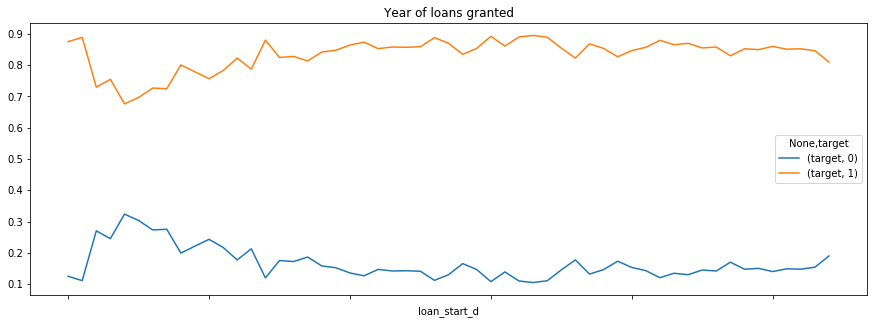

In [3]:
loan_start = lend.groupby(['loan_start_d', 'target'])[['target']].count().unstack(level=1)
loan_start = loan_start.apply(lambda r:r/r.sum(), axis=1)
loan_start.plot(kind='line', figsize =(15, 5), title='Year of loans granted');

Loan issued during 2008 and prior had higher default rate, probably due to financial crisis. Given one cannot predict when the next financial crisis is going to happen, data within 2007 and 2008, unfortunately, will be outliers for the dataset and would need to removed from the analysis

In [4]:
lend_post_2008 = lend[lend['loan_start_d'] >= '2009-1-1']

To simplify the repetition steps for creating visualization, the following function is created

In [5]:
def visual_data(x):
    y = lend_post_2008.groupby([x,'target'])[['target']].count().unstack(level=1)
    z = y.apply(lambda r: r/r.sum(), axis=1)
    return z

#### The following attributes will be assessed
- Employment length
- Property ownership
- Loan purpose
- Credit line history
- Debt to income ratio (DTI)
- Credit utilization rate

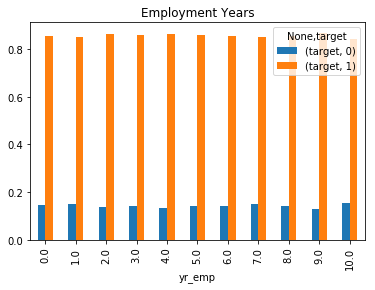

In [6]:
emp_data = visual_data('yr_emp')
emp_data.plot(kind='bar', title='Employment Years');

- Employment time does not indicate obvious correlation on loan pay off rate

RENT        16861
MORTGAGE    16471
OWN          2840
OTHER          10
Name: home_ownership, dtype: int64

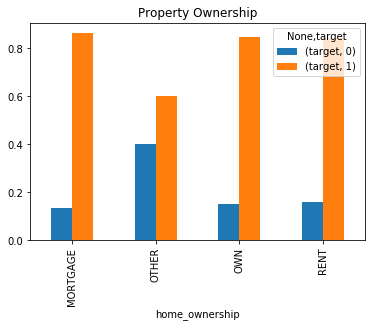

In [7]:
ownership = visual_data('home_ownership')
ownership.plot(kind='bar', title='Property Ownership');
lend_post_2008['home_ownership'].value_counts()

- Owning a property or rent does not indicate obvious correlation on loan pay off rate. Other category has high default rate but the small sample size does make the correlation significant

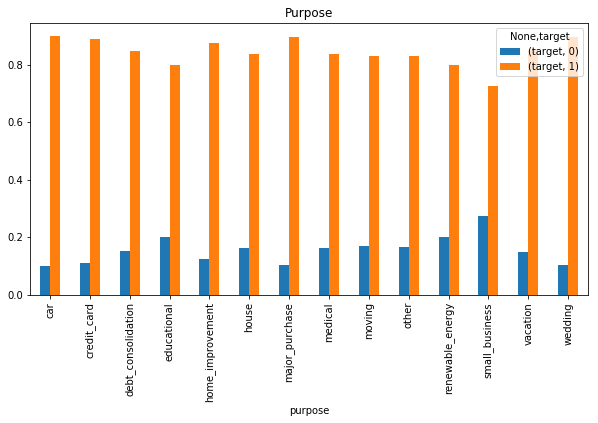

In [8]:
loan_purpose = visual_data('purpose')
loan_purpose.plot(kind='bar', figsize=(10,5), title='Purpose');

- Default rate varies by purpose. Among those, educational and small_business seem to have highest charge off rate, versus wedding has the lowest

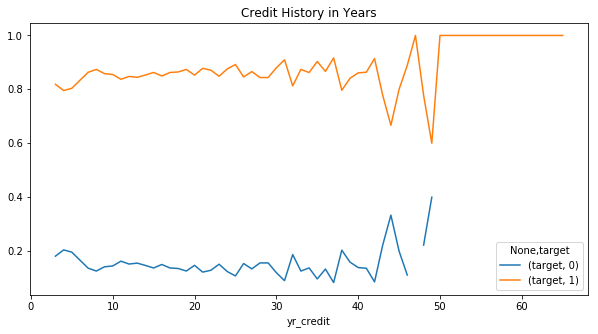

In [9]:
yr_credit_g = visual_data('yr_credit')
dti_g = visual_data('dti')
revutil = visual_data('revol_util_dec')
cred_acc = visual_data('total_acc')

yr_credit_g.plot(kind='line', figsize=(10,5), title='Credit History in Years');

 - Charge off rate go up from 0-5yrs, then gradually drop toward 10yrs. Post that the default rate stay roughly the same till 30 yrs plus, and that could be driven by outliers due to small sample size.

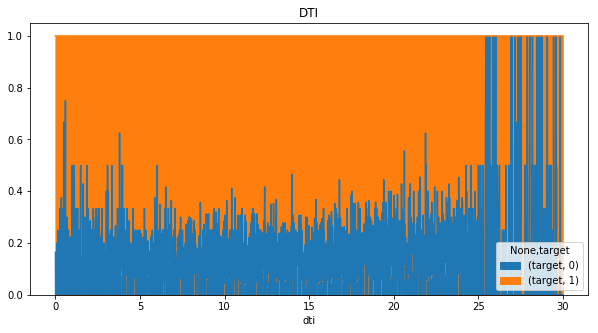

In [10]:
dti_g.plot(kind='area', figsize=(10,5), title='DTI');

 - While not extremely strong, the increase of dti has positive correlation with default rates

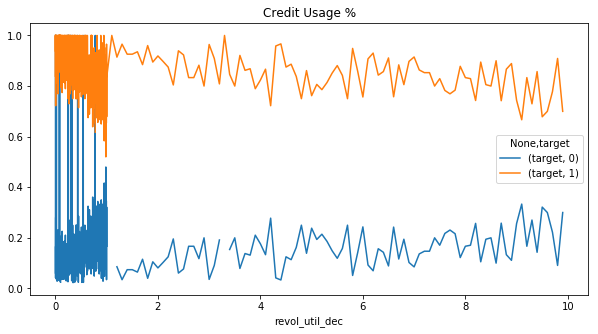

In [11]:
revutil.plot(kind='line', figsize=(10,5), title='Credit Usage %');

- Credit usage show slight negative correlation with loan pay off rate

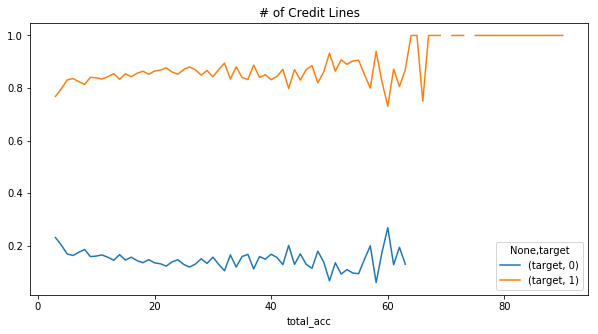

In [12]:
cred_acc.plot(kind='line', figsize=(10,5), title='# of Credit Lines');

- Number of credit line is inversely correlated to default rates

### Recommendation

- Loan Purposes has noticeable impact on the loan repayment rate. Loans to fund new businesses have the highest default rate. Loans for major life events such as wedding and major purchases have lower chance of default.
- Years of credit history, DTI, and number of credit lines also indicate correlation to loan default rates, and will need further analysis